Fold 1 Results — MAE: 6.06, RMSE: 12.19, R2: 0.9934, Adj R2: 0.9934
Fold 2 Results — MAE: 2.09, RMSE: 3.74, R2: 0.9992, Adj R2: 0.9992
Fold 3 Results — MAE: 7.13, RMSE: 26.15, R2: 0.9783, Adj R2: 0.9782
Fold 4 Results — MAE: 6.38, RMSE: 16.80, R2: 0.9942, Adj R2: 0.9941
Fold 5 Results — MAE: 4.08, RMSE: 9.78, R2: 0.9980, Adj R2: 0.9980


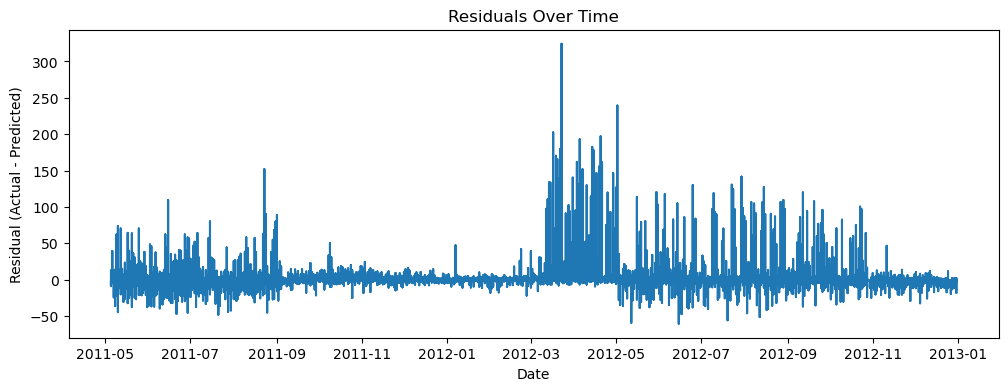


MAE by season:
season
1    3.172938
2    8.336412
3    5.906628
4    2.975418
Name: residual, dtype: float64


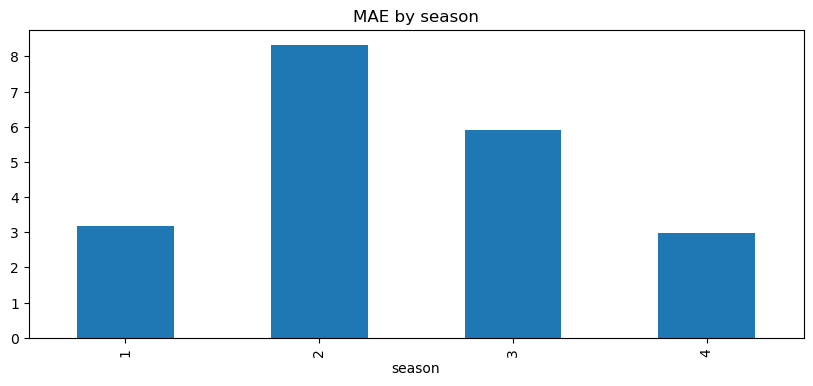


MAE by weathersit_grouped:
weathersit_grouped
1    5.878510
2    3.891260
3    2.896184
Name: residual, dtype: float64


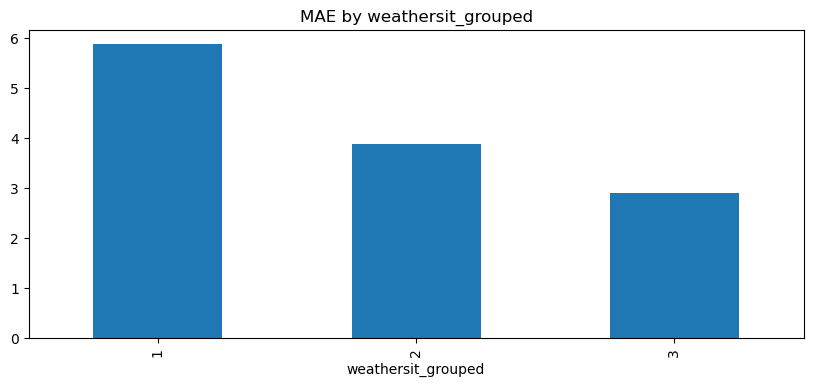


MAE by hr:
hr
0      0.956628
1      0.680592
2      0.614026
3      0.380261
4      0.278174
5      0.398367
6      1.028270
7      3.353932
8     13.283219
9      2.957223
10     2.256879
11     3.626878
12     6.337426
13     6.657358
14     6.270861
15     6.180400
16     7.884140
17    25.513571
18    19.873428
19     5.908735
20     3.787867
21     2.161318
22     1.710988
23     1.120823
Name: residual, dtype: float64


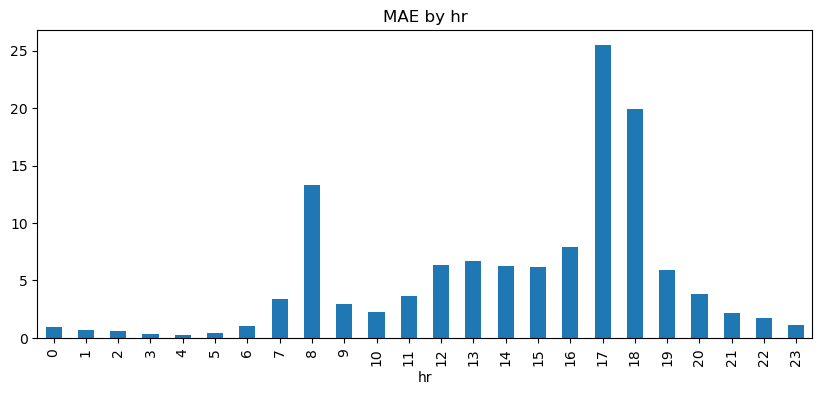


MAE by weekday:
weekday
0    4.567785
1    4.885650
2    5.233488
3    5.548357
4    5.186110
5    4.355225
6    6.255537
Name: residual, dtype: float64


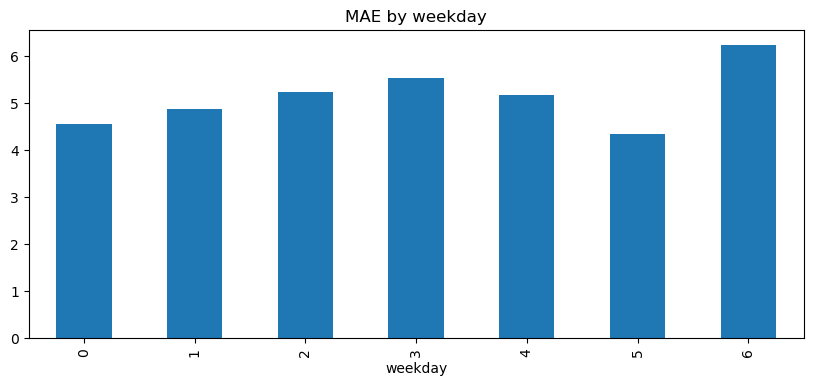


MAE by temp_bin:
temp_bin
1    5.146834
Name: residual, dtype: float64


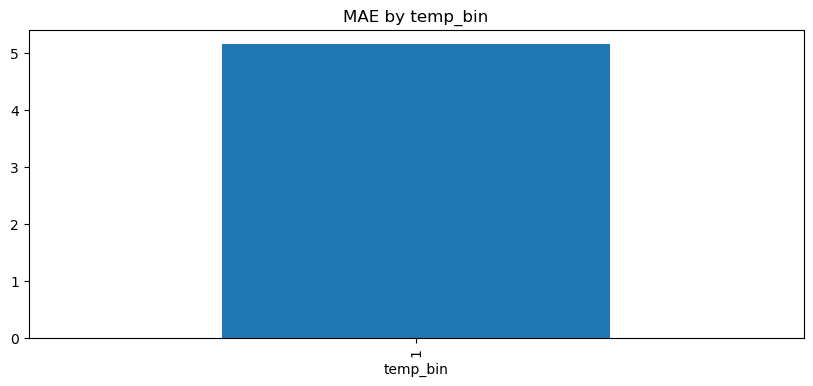


MAE by hum_bin:
hum_bin
0.0    5.146834
Name: residual, dtype: float64


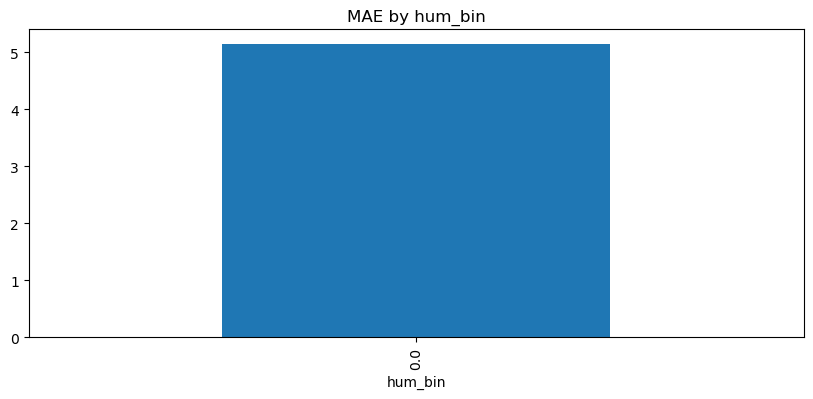

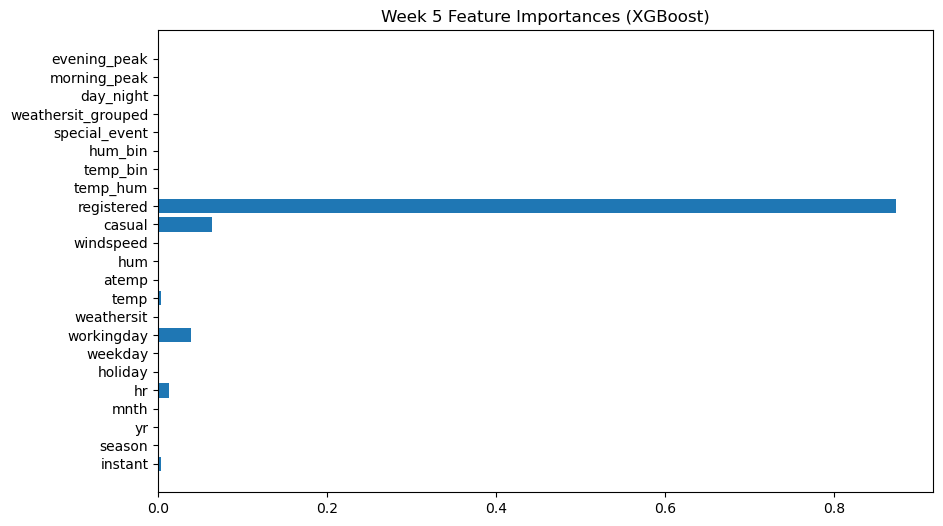


✅ Week 5 features & error analysis completed and saved.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# ---------------------------
# 1️⃣ Load Dataset
# ---------------------------
df = pd.read_csv("data/hour.csv", parse_dates=["dteday"])

# ---------------------------
# 2️⃣ Advanced Feature Engineering
# ---------------------------

# Interaction features
df['temp_hum'] = df['temp'] * df['hum']

# Binning features
df['temp_bin'] = pd.cut(df['temp'], bins=[-5,0,10,20,30,40], labels=False)
df['hum_bin'] = pd.cut(df['hum'], bins=[0,20,40,60,80,100], labels=False)

# Special event / holiday flags
special_dates = pd.to_datetime(['2012-10-29'])  # Example: Hurricane Sandy
df['special_event'] = df['dteday'].isin(special_dates).astype(int)

# Weather grouping (combine rare categories)
df['weathersit_grouped'] = df['weathersit'].replace({4:3})

# Hourly flags (day/night, commuting peaks)
df['day_night'] = df['hr'].apply(lambda x: 1 if 6 <= x <= 18 else 0)
df['morning_peak'] = df['hr'].apply(lambda x: 1 if 7 <= x <= 9 else 0)
df['evening_peak'] = df['hr'].apply(lambda x: 1 if 17 <= x <= 19 else 0)

# Convert categorical columns to category dtype
categorical_cols = ['season','weathersit_grouped','hr','weekday','temp_bin','hum_bin']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Create a unique key for residual mapping
df['date_hr'] = df['dteday'].astype(str) + "_" + df['hr'].astype(str)

# ---------------------------
# 3️⃣ Prepare Features & Target
# ---------------------------
feature_cols = df.drop(columns=['cnt','dteday','date_hr']).columns
X = df[feature_cols]
y = df['cnt']

# ---------------------------
# 4️⃣ Time Series CV
# ---------------------------
tscv = TimeSeriesSplit(n_splits=5)

# ---------------------------
# 5️⃣ Train XGBoost & Collect Residuals
# ---------------------------
residuals_df = pd.DataFrame()

for fold, (train_idx, valid_idx) in enumerate(tscv.split(X), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1,
        enable_categorical=True
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # Residuals
    temp_df = pd.DataFrame({
        'date_hr': df['date_hr'].iloc[valid_idx],
        'residual': y_valid - y_pred
    })
    residuals_df = pd.concat([residuals_df, temp_df], ignore_index=True)
    
    # Fold metrics
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    n, p = len(y_valid), X_valid.shape[1]
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    
    print(f"Fold {fold} Results — MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, Adj R2: {adj_r2:.4f}")

# ---------------------------
# 6️⃣ Error Analysis Plots
# ---------------------------
# Residuals over time
plt.figure(figsize=(12,4))
plt.plot(pd.to_datetime(residuals_df['date_hr'].str.split("_").str[0]), residuals_df['residual'])
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

# MAE by categorical features with observed=False to silence warning
for col in categorical_cols:
    residuals_df[col] = residuals_df['date_hr'].map(df.set_index('date_hr')[col])
    mae_by_col = residuals_df.groupby(col, observed=False)['residual'].apply(lambda x: np.mean(np.abs(x)))
    print(f"\nMAE by {col}:\n{mae_by_col}")
    mae_by_col.plot(kind='bar', figsize=(10,4), title=f"MAE by {col}")
    plt.show()

# ---------------------------
# 7️⃣ Feature Importance
# ---------------------------
model.fit(X, y)  # train on all data
importances = model.feature_importances_

plt.figure(figsize=(10,6))
plt.barh(feature_cols, importances)
plt.title("Week 5 Feature Importances (XGBoost)")
plt.show()

# ---------------------------
# 8️⃣ Save Features & Analysis
# ---------------------------
df.to_csv("results/hour_features_week5.csv", index=False)
print("\n✅ Week 5 features & error analysis completed and saved.")
